In [101]:
import math
import numpy as np
import matplotlib.pyplot as plt

import plotly
import plotly.plotly as py
import plotly.graph_objs as go

%matplotlib inline

plotly.offline.init_notebook_mode(connected=True)
from IPython.core.display import display, HTML, Markdown
# The polling here is to ensure that plotly.js has already been loaded before
# setting display alignment in order to avoid a race condition.
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

import colorlover as cl

def formatted(f): 
    return format(f, '.2f').rstrip('0').rstrip('.')

In [102]:
seed_train = 1
seed_test = 2

sample_sizes = np.arange(100, 10100, 100)

error = {}

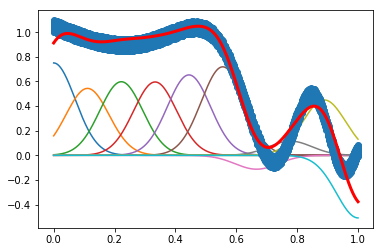

In [103]:
numFeatures = 10


def generateDataSample(x):
	"""
	Generate a noisy data sample from a given data point in the range [0,1]

	:param x: A scalar dependent variable for which to calculate the output y_noisy
		
	:returns: The output with gaussian noise added
		
	"""
	y = 1 - x - math.sin(-2 * math.pi * x ** 3) * math.cos(-2 * math.pi * x ** 3) * math.exp(-x ** 4)
	sigma = 0.1
	noise = sigma * np.random.random()
	y_noisy = y + noise
	return y_noisy

centers = np.linspace(0.0, 1.0, numFeatures)
widthConstant = (1.0 - 0.0) / numFeatures / 10
widths = np.ones(numFeatures,) * widthConstant
alpha = 0.9

def phiOutput(input):
	"""
	Get the output of the Gaussian features for a given input variable(s)
	
	:param input: A single or vector of dependent variables with size [Ns] for which to calculate the FA features
	
	:returns: A vector of feature outputs with size [NumFeats x Ns]
	"""
	global numFeatures, centers, widths
	if np.size(input) == 1: 
		phi = np.exp(-np.divide(np.square(input - centers), widths))
	elif np.size(input) > 1:
		numEvals = np.shape(input)[0]
		# Repeat vectors to vectorize output calculation
		inputMat = np.array([input, ] * numFeatures)
		centersMat = np.array([centers, ] * numEvals).transpose()
		widthsMat = np.array([widths, ] * numEvals).transpose() 
		phi = np.exp(-np.divide(np.square(inputMat - centersMat), widthsMat))	
	return phi

def f(input, *user_theta):
	"""
	Get the FA output for a given input variable(s)
	
	:param input: A single or vector of dependent variables with size [Ns] for which to calculate the FA features
	:param user_theta: (Variable argument) A vector of theta variables to apply to the FA. If left blank the method will default to using the trained thetas in self.theta. This is only used for visualization purposes.
		
	:returns: A vector of function approximator outputs with size [Ns]
	"""
	global theta
	phi = phiOutput(input)	
	if not user_theta:
		Theta = theta
	else:
		Theta = np.array(user_theta)	
	out = np.dot(phi, Theta.transpose())	
	return out

generateDataSample = np.vectorize(generateDataSample)
f = np.vectorize(f)

model = 'GD'
error[model] = {}
error[model]['train'] = []
error[model]['test'] = []


for sample_size in sample_sizes:
    theta = np.random.random(numFeatures)

    xHistory = []
    yHistory = []

    error_evolution = []

    np.random.seed(seed_train)

    def train_GD(maxIter):
        global theta, xHistory, yHistory, alpha, E
        iterationCount = 0
        while iterationCount < maxIter:			
            #----------------------#
            #  Training Algorithm  #
            #----------------------#

            # Draw a random sample on the interval [0,1]
            x = np.random.random() 
            y = generateDataSample(x)
            xHistory.append(x)
            yHistory.append(y)

            #-----------------------------#
            #         Modifications       #
            #-----------------------------#
            fval = f(x)
            e = y - fval
            delta = phiOutput(x)
            theta += alpha*e*delta

            error_evolution.append(e)
            #-----------------------------#
            #  End of Training Algorithm  #
            #-----------------------------#
            iterationCount += 1
    
    train_GD(sample_size)
    
    error[model]['train'].append(np.mean(np.abs(np.array(error_evolution))))
    
    np.random.seed(seed_test)
    xs_test = np.random.random(sample_size)
    error[model]['test'].append(np.mean(np.abs(generateDataSample(xs_test) - f(xs_test))))
    


#----------- Plotting ---------------#
xs = np.linspace(0.0,1.0,1000)
z = map(f, xs)
idx = 0
def feat(input):
	global theta, idx
	phi = phiOutput(input)
	return phi[idx] * theta[idx]
for i in range(numFeatures):
	idx = i 
	z2 = map(feat, xs)
	plt.plot(xs, z2)
plt.plot(xHistory, yHistory, 'o')
plt.plot(xs, z, lw = 3, color = 'red')
plt.show()

In [104]:
data1 = [
    go.Scatter(
        x=sample_sizes,
        y=error['GD']['train'],
        name='Train error'
    )
]


data2 = [
    go.Scatter(
        x=sample_sizes,
        y=error['GD']['test'],
        name='Test error'
    )
]


layout = go.Layout(
    title='Comparison of train and test error for gradient descent',
    xaxis=dict(
        title='Number of input data points'
    ),
    yaxis=dict(
        title='Average Error',
        ticklen= 5,
        gridwidth= 2
    )
)


plotly.offline.iplot(go.Figure(data=data1+data2, layout=layout))

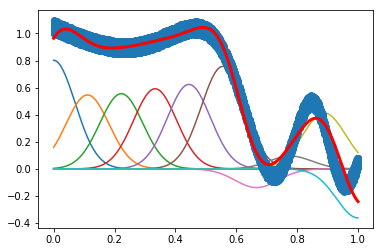

In [105]:
numFeatures = 10

def generateDataSample(x):
	"""
	Generate a noisy data sample from a given data point in the range [0,1]

	:param x: A scalar dependent variable for which to calculate the output y_noisy
		
	:returns: The output with gaussian noise added
		
	"""
	y = 1 - x - math.sin(-2 * math.pi * x ** 3) * math.cos(-2 * math.pi * x ** 3) * math.exp(-x ** 4)
	sigma = 0.1
	noise = sigma * np.random.random()
	y_noisy = y + noise
	return y_noisy

centers = np.linspace(0.0, 1.0, numFeatures)
widthConstant = (1.0 - 0.0) / numFeatures / 10
widths = np.ones(numFeatures,) * widthConstant

def phiOutput(input):
	"""
	Get the output of the Gaussian features for a given input variable(s)
	
	:param input: A single or vector of dependent variables with size [Ns] for which to calculate the FA features
	
	:returns: A vector of feature outputs with size [NumFeats x Ns]
	"""
	global numFeatures, centers, widths
	if np.size(input) == 1: 
		phi = np.exp(-np.divide(np.square(input - centers), widths))	
	elif np.size(input) > 1:
		numEvals = np.shape(input)[0]
		# Repeat vectors to vectorize output calculation
		inputMat = np.array([input, ] * numFeatures)
		centersMat = np.array([centers, ] * numEvals).transpose() 
		widthsMat = np.array([widths, ] * numEvals).transpose() 
		phi = np.exp(-np.divide(np.square(inputMat - centersMat), widthsMat))	
	return phi

def f(input, *user_theta):
	"""
	Get the FA output for a given input variable(s)
	
	:param input: A single or vector of dependent variables with size [Ns] for which to calculate the FA features
	:param user_theta: (Variable argument) A vector of theta variables to apply to the FA. If left blank the method will default to using the trained thetas in self.theta. This is only used for visualization purposes.
		
	:returns: A vector of function approximator outputs with size [Ns]
	"""
	global theta
	phi = phiOutput(input)	
	if not user_theta:
		Theta = theta
	else:
		Theta = np.array(user_theta)	
	out = np.dot(phi, Theta.transpose())	
	return out

generateDataSample = np.vectorize(generateDataSample)
f = np.vectorize(f)

model = 'LS'
error[model] = {}
error[model]['train'] = []
error[model]['test'] = []


for sample_size in sample_sizes:
    theta = np.random.random(numFeatures)
    
    np.random.seed(seed_train)
    x = np.random.random(sample_size)
    y = map(generateDataSample, x)

    def train_LS():
        global x, y, numfeatures, theta			
        #----------------------#
        # # Training Algorithm ##
        #----------------------#

        Phi = phiOutput(x)
        A = Phi.dot(Phi.T)
        b = Phi.dot(y)
        theta = np.dot(np.linalg.pinv(A),b)

        #-----------------------------#
        # # End of Training Algorithm ##
        #-----------------------------#

    train_LS()
    
    error[model]['train'].append(np.mean(np.abs(y - f(x))))
    
    np.random.seed(seed_test)
    xs_test = np.random.random(sample_size)
    error[model]['test'].append(np.mean(np.abs(generateDataSample(xs_test) - f(xs_test))))


#----------- Plotting ---------------#
xs = np.linspace(0.0, 1.0, 1000)
z = map(f, xs)
idx = 0
def feat(input):
	global theta, idx
	phi = phiOutput(input)
	return phi[idx] * theta[idx]
for i in range(numFeatures):
	idx = i 
	z2 = map(feat, xs)
	plt.plot(xs, z2)
plt.plot(x, y, 'o')
plt.plot(xs, z, lw=3, color='red')
plt.show()

In [106]:
data1 = [
    go.Scatter(
        x=sample_sizes,
        y=error['LS']['train'],
        name='Train error'
    )
]


data2 = [
    go.Scatter(
        x=sample_sizes,
        y=error['LS']['test'],
        name='Test error'
    )
]


layout = go.Layout(
    title='Comparison of train and test error for the Least Squares method',
    xaxis=dict(
        title='Number of input data points'
    ),
    yaxis=dict(
        title='Average Error',
        ticklen= 5,
        gridwidth= 2
    )
)


plotly.offline.iplot(go.Figure(data=data1+data2, layout=layout))

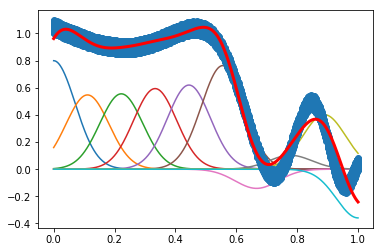

In [107]:
numFeatures = 10

def generateDataSample(x):
	"""
	Generate a noisy data sample from a given data point in the range [0,1]

	:param x: A scalar dependent variable for which to calculate the output y_noisy
		
	:returns: The output with gaussian noise added
		
	"""
	y = 1 - x - math.sin(-2 * math.pi * x ** 3) * math.cos(-2 * math.pi * x ** 3) * math.exp(-x ** 4)
	sigma = 0.1
	noise = sigma * np.random.random()
	y_noisy = y + noise
	return y_noisy

centers = np.linspace(0.0, 1.0, numFeatures)
widthConstant = (1.0 - 0.0) / numFeatures / 10
widths = np.ones(numFeatures,) * widthConstant

def phiOutput(input):
	"""
	Get the output of the Gaussian features for a given input variable(s)
	
	:param input: A single or vector of dependent variables with size [Ns] for which to calculate the FA features
	
	:returns: A vector of feature outputs with size [NumFeats x Ns]
	"""
	global numFeatures, centers, widths
	if np.size(input) == 1: 
		phi = np.exp(-np.divide(np.square(input - centers), widths))	
	elif np.size(input) > 1:
		numEvals = np.shape(input)[0]
		# Repeat vectors to vectorize output calculation
		inputMat = np.array([input, ] * numFeatures)
		centersMat = np.array([centers, ] * numEvals).transpose() 
		widthsMat = np.array([widths, ] * numEvals).transpose() 
		phi = np.exp(-np.divide(np.square(inputMat - centersMat), widthsMat))	
	return phi

def f(input, *user_theta):
	"""
	Get the FA output for a given input variable(s)
	
	:param input: A single or vector of dependent variables with size [Ns] for which to calculate the FA features
	:param user_theta: (Variable argument) A vector of theta variables to apply to the FA. If left blank the method will default to using the trained thetas in self.theta. This is only used for visualization purposes.
		
	:returns: A vector of function approximator outputs with size [Ns]
	"""
	global theta
	phi = phiOutput(input)	
	if not user_theta:
		Theta = theta
	else:
		Theta = np.array(user_theta)	
	out = np.dot(phi, Theta.transpose())	
	return out


generateDataSample = np.vectorize(generateDataSample)
f = np.vectorize(f)

model = 'RLS'
error[model] = {}
error[model]['train'] = []
error[model]['test'] = []

for sample_size in sample_sizes:

    xHistory = []
    yHistory = []
    error_evolution = []
    
    np.random.seed(seed_train) 

    def train_RLS(maxIter):	
        global theta, xHistory, yHistory, E

        ## Initialize A and b ##
        A = np.zeros(shape=(numFeatures,numFeatures))
        b = np.zeros( numFeatures )

        iterationCount = 0
        # Begin training
        while iterationCount < maxIter:

            # Draw a random sample on the interval [0,1]
            x = np.random.random() 
            y = generateDataSample(x)
            xHistory.append(x)
            yHistory.append(y)

            e=0
            #----------------------#
            ## Training Algorithm ##
            #----------------------#

            theta = np.zeros((numFeatures,))

            A += np.outer(phiOutput(x),phiOutput(x))
            b += phiOutput(x)*y

            theta = np.dot(np.linalg.pinv(A),b)
            
            error_evolution.append(y - f(x))

            #-----------------------------#
            ## End of Training Algorithm ##
            #-----------------------------#

            iterationCount+=1

        theta = np.dot(np.linalg.pinv(A),b)

    train_RLS(sample_size)
        
    error[model]['train'].append(np.mean(np.abs(np.array(error_evolution))))
    
    np.random.seed(seed_test)
    xs_test = np.random.random(sample_size)
    error[model]['test'].append(np.mean(np.abs(generateDataSample(xs_test) - f(xs_test))))
    
    

#----------- Plotting ---------------#
xs = np.linspace(0.0,1.0,1000)
z = map(f, xs)
idx = 0
def feat(input):
	global theta, idx
	phi = phiOutput(input)
	return phi[idx] * theta[idx]
for i in range(numFeatures):
	idx = i 
	z2 = map(feat, xs)
	plt.plot(xs, z2)
plt.plot(xHistory, yHistory, 'o')
plt.plot(xs, z, lw = 3, color = 'red')
plt.show()


In [108]:
data1 = [
    go.Scatter(
        x=sample_sizes,
        y=error['RLS']['train'],
        name='Train error'
    )
]


data2 = [
    go.Scatter(
        x=sample_sizes,
        y=error['RLS']['test'],
        name='Test error'
    )
]


layout = go.Layout(
    title='Comparison of train and test error for the Recursive Least Squares method',
    xaxis=dict(
        title='Number of input data points'
    ),
    yaxis=dict(
        title='Average Error',
        ticklen= 5,
        gridwidth= 2
    )
)


plotly.offline.iplot(go.Figure(data=data1+data2, layout=layout))

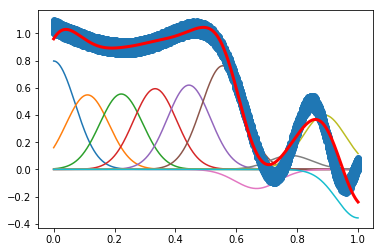

In [109]:
numFeatures = 10

def generateDataSample(x):
	"""
	Generate a noisy data sample from a given data point in the range [0,1]

	:param x: A scalar dependent variable for which to calculate the output y_noisy
		
	:returns: The output with gaussian noise added
		
	"""
	y = 1 - x - math.sin(-2 * math.pi * x ** 3) * math.cos(-2 * math.pi * x ** 3) * math.exp(-x ** 4)
	sigma = 0.1
	noise = sigma * np.random.random()
	y_noisy = y + noise
	return y_noisy

centers = np.linspace(0.0, 1.0, numFeatures)
widthConstant = (1.0 - 0.0) / numFeatures / 10
widths = np.ones(numFeatures,) * widthConstant

def phiOutput(input):
	"""
	Get the output of the Gaussian features for a given input variable(s)
	
	:param input: A single or vector of dependent variables with size [Ns] for which to calculate the FA features
	
	:returns: A vector of feature outputs with size [NumFeats x Ns]
	"""
	global numFeatures, centers, widths
	if np.size(input) == 1: 
		phi = np.exp(-np.divide(np.square(input - centers), widths))	
	elif np.size(input) > 1:
		numEvals = np.shape(input)[0]
		# Repeat vectors to vectorize output calculation
		inputMat = np.array([input, ] * numFeatures)
		centersMat = np.array([centers, ] * numEvals).transpose() 
		widthsMat = np.array([widths, ] * numEvals).transpose() 
		phi = np.exp(-np.divide(np.square(inputMat - centersMat), widthsMat))	
	return phi

def f(input, *user_theta):
	"""
	Get the FA output for a given input variable(s)
	
	:param input: A single or vector of dependent variables with size [Ns] for which to calculate the FA features
	:param user_theta: (Variable argument) A vector of theta variables to apply to the FA. If left blank the method will default to using the trained thetas in self.theta. This is only used for visualization purposes.
		
	:returns: A vector of function approximator outputs with size [Ns]
	"""
	global theta
	phi = phiOutput(input)	
	if not user_theta:
		Theta = theta
	else:
		Theta = np.array(user_theta)	
	out = np.dot(phi, Theta.transpose())	
	return out

generateDataSample = np.vectorize(generateDataSample)
f = np.vectorize(f)

model = 'RLS2'
error[model] = {}
error[model]['train'] = []
error[model]['test'] = []

for sample_size in sample_sizes:

    xHistory = []
    yHistory = []
    error_evolution = []
    
    np.random.seed(seed_train) 

    def train_RLS(maxIter):	
        global theta, xHistory, yHistory, E

        ## Initialize b and A_sharp ##
        b = np.zeros( numFeatures )
        A_sharp = np.eye(numFeatures)

        iterationCount = 0
        # Begin training
        while iterationCount < maxIter:

            # Draw a random sample on the interval [0,1]
            x = np.random.random() 
            y = generateDataSample(x)
            xHistory.append(x)
            yHistory.append(y)
            #----------------------#
            ## Training Algorithm ##
            #----------------------#

            phi = phiOutput(x)

            A_sharp -= A_sharp.dot(np.outer(phi, phi).dot(A_sharp))/(1+phi.dot(A_sharp.dot(phi)))
            b += phi.dot(y)

            error_evolution.append(y - f(x))

            #-----------------------------#
            ## End of Training Algorithm ##
            #-----------------------------#

            iterationCount+=1

        theta = np.dot(A_sharp,b)

    train_RLS(sample_size)
    
    error[model]['train'].append(np.mean(np.abs(np.array(error_evolution))))
    
    np.random.seed(seed_test)
    xs_test = np.random.random(sample_size)
    error[model]['test'].append(np.mean(np.abs(generateDataSample(xs_test) - f(xs_test))))

    
#----------- Plotting ---------------#
xs = np.linspace(0.0,1.0,1000)
z = map(f, xs)
idx = 0
def feat(input):
	global theta, idx
	phi = phiOutput(input)
	return phi[idx] * theta[idx]
for i in range(numFeatures):
	idx = i 
	z2 = map(feat, xs)
	plt.plot(xs, z2)
plt.plot(xHistory, yHistory, 'o')
plt.plot(xs, z, lw = 3, color = 'red')
plt.show()


In [110]:
data1 = [
    go.Scatter(
        x=sample_sizes,
        y=error['RLS2']['train'],
        name='Train error'
    )
]


data2 = [
    go.Scatter(
        x=sample_sizes,
        y=error['RLS2']['test'],
        name='Test error'
    )
]


layout = go.Layout(
    title='Comparison of train and test error for the Recursive Least Squares method with Sherman-Morrison',
    xaxis=dict(
        title='Number of input data points'
    ),
    yaxis=dict(
        title='Average Error',
        ticklen= 5,
        gridwidth= 2
    )
)


plotly.offline.iplot(go.Figure(data=data1+data2, layout=layout))

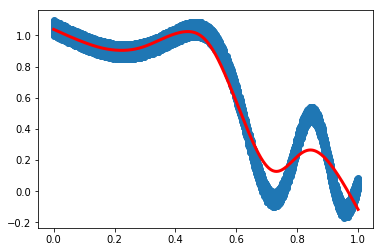

In [111]:
numFeatures = 10

def generateDataSample(x):
	"""
	Generate a noisy data sample from a given data point in the range [0,1]

	:param x: A scalar dependent variable for which to calculate the output y_noisy
		
	:returns: The output with gaussian noise added
		
	"""
	y = 1 - x - math.sin(-2 * math.pi * x ** 3) * math.cos(-2 * math.pi * x ** 3) * math.exp(-x ** 4)
	sigma = 0.1
	noise = sigma * np.random.random()
	y_noisy = y + noise
	return y_noisy

centers = np.linspace(0.0, 1.0, numFeatures)
widthConstant = (1.0 - 0.0) / numFeatures / 10
widths = np.ones(numFeatures,) * widthConstant

def phiOutput(input):
	"""
	Get the output of the Gaussian features for a given input variable(s)
	
	:param input: A single or vector of dependent variables with size [Ns] for which to calculate the FA features
	
	:returns: A vector of feature outputs with size [NumFeats x Ns]
	"""
	global numFeatures, centers, widths
	if np.size(input) == 1: 
		phi = np.exp(-np.divide(np.square(input - centers), widths))	
	elif np.size(input) > 1:
		numEvals = np.shape(input)[0]
		# Repeat vectors to vectorize output calculation
		inputMat = np.array([input, ] * numFeatures)
		centersMat = np.array([centers, ] * numEvals).transpose() 
		widthsMat = np.array([widths, ] * numEvals).transpose() 
		phi = np.exp(-np.divide(np.square(inputMat - centersMat), widthsMat))	
	return phi

def w(input):
	"""
	Get the output of the features for a given input variable(s)
	
	:param input: A single or vector of dependent variables with size [Ns] for which to calculate the FA features
	
	:returns: A vector of feature outputs with size [NumFeats x Ns]
	"""		
	if np.size(input) == 1:
		w = np.vstack(([input], [1]))
			
	elif np.size(input) > 1:
		w = np.vstack((input, np.ones((1,np.size(input)))))			
	return w

def f(input):
	"""
	Get the FA output for a given input variable(s)
	
	:param input: A single or vector of dependent variables with size [Ns] for which to calculate the FA features
	
	:returns: A vector of function approximator outputs with size [Ns]
	"""
	global theta
	wval = w(input)
	Phi = phiOutput(input)
	g = (np.dot(wval.transpose(), theta)).transpose() #[numFeats x Ns]
	out = np.sum(Phi*g, axis=0) / np.sum(Phi, axis=0)
	return out

generateDataSample = np.vectorize(generateDataSample)

model = 'LWLS'
error[model] = {}
error[model]['train'] = []
error[model]['test'] = []

for sample_size in sample_sizes:

    theta = np.zeros((2, numFeatures))
    
    np.random.seed(seed_train)
    x = np.random.random(sample_size)
    y = map(generateDataSample, x)

    def train_LWLS():
        global x, y, numFeatures, theta		

        #----------------------#
        ## Training Algorithm ##
        #----------------------#

        Phi = phiOutput(x)
        W = w(x)

        for k in range(numFeatures):
            Wphi = W.dot(np.diag(Phi[k]))
            A_i = Wphi.dot(W.T)
            b_i = Wphi.dot(y)
            theta[:,k] = np.dot(np.linalg.pinv(A_i),b_i)

        #-----------------------------#	
        ## End of Training Algorithm ##	
        #-----------------------------#

    train_LWLS()
    
    error[model]['train'].append(np.mean(np.abs(np.array(y - f(x)))))
    
    np.random.seed(seed_test)
    xs_test = np.random.random(sample_size)
    error[model]['test'].append(np.mean(np.abs(generateDataSample(xs_test) - f(xs_test))))

#----------- Plotting ---------------#
xs = np.linspace(0.0, 1.0, 1000)
z = f(xs)
plt.plot(x, y, 'o')
plt.plot(xs, z, lw=3, color='red')
plt.show()	

In [113]:
data1 = [
    go.Scatter(
        x=sample_sizes,
        y=error['LWLS']['train'],
        name='Train error'
    )
]


data2 = [
    go.Scatter(
        x=sample_sizes,
        y=error['LWLS']['test'],
        name='Test error'
    )
]


layout = go.Layout(
    title='Comparison of train and test error for the Locally Weighted Least Squares method',
    xaxis=dict(
        title='Number of input data points'
    ),
    yaxis=dict(
        title='Average Error',
        ticklen= 5,
        gridwidth= 2
    )
)


plotly.offline.iplot(go.Figure(data=data1+data2, layout=layout))

In [114]:
layout_fin = go.Layout(
    title= 'Comparison of train and test errors for all the models',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Number of input data points',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Average Error',
        ticklen= 5,
        gridwidth= 2,
    )
) 


legend_every = 1

models = ['GD', 'LS', 'RLS', 'RLS2', 'LWLS']

colors = cl.scales['{}'.format(2*len(models))]['qual']['Paired']

# Plotting the evolution
traces = []

for i, m in enumerate(models):
    for j, test_train in enumerate(['test', 'train']):
        traces.append(
            go.Scatter(
                x = sample_sizes, 
                y = error[m][test_train],
                mode = 'lines',
                name = '{}: {} error'.format(m, test_train),
                line = dict(
                    width = 2,
                    color = colors[2*i+j],
                    dash = 'solid'
                ),
                hoverlabel = dict(
                    namelength = -1
                ),
                showlegend = (i % legend_every == 0)
            )
        )

plotly.offline.iplot(go.Figure(data=traces, layout=layout_fin))

In [115]:
trace_bar = {}

def bar_chart_error(list_classifiers, trace_bar = trace_bar):
    learning_sets = np.arange(1, 10)
    
    colors = cl.scales['{}'.format(2*len(list_classifiers))]['qual']['Paired']

    for i, classifier in enumerate(list_classifiers):
        trace_bar[classifier] = {}
        for j, test_train in enumerate(['test', 'train']):
            trace_bar[classifier][test_train] = go.Bar(
                x = ['{} k'.format(k) for k in learning_sets],
                y = [error[classifier][test_train][10*k] for k in learning_sets],
                name = '{}: {} error'.format(classifier, test_train),
                marker=dict(
                    color=colors[2*i+j],
                ),
                opacity=0.75
            )
    
    return trace_bar

list_classifiers = ['GD', 'LS', 'RLS', 'RLS2', 'LWLS']

trace_bar = bar_chart_error(list_classifiers)

layout_bar = go.Layout(
    barmode='group',
    title = 'Average Errors: Comparison',
    xaxis = dict(
        title='Number of data points'
    ),
    yaxis = dict(
        title = 'Error'
    ),
)
fig = go.Figure(data=[trace_bar[key][tt] for key in trace_bar for tt in trace_bar[key]], layout=layout_bar)
plotly.offline.iplot(fig)